# An Exploration of UW Pharmacy Student Reflections

Author: Marlon Fu (marlonfu@berkeley.edu)

## Libraries and Dependencies

In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
%matplotlib inline


import nltk
from nltk.util import ngrams
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
from sklearn.feature_extraction.text import TfidfVectorizer

from collections import Counter

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess

import pyLDAvis

import spacy

[nltk_data] Downloading package stopwords to /Users/bing/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/bing/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Import and Pre-process Data

In [7]:
data = pd.read_csv("data/choiceboard_data.csv")[["CPD_Q1", "CPD_Q3"]]
data.head()

,CPD_Q1,CPD_Q3
0,The class time devoted to health and wellness ...,I believe self-care to be really important in ...
1,The class time devoted to health and wellness ...,The time spent on my choice of self-care allow...
2,The class time has reminded me on the importan...,The time spent on my choice of self care affec...
3,The class time that was devoted to health and ...,It made me more relaxed and less stressed abou...
4,I have learnt to listen to people without inte...,This has been a lifeline because I always felt...


In [8]:
corpus_1 = data["CPD_Q1"].dropna()
corpus_1 = corpus_1.astype(str)
corpus_1

0      The class time devoted to health and wellness ...
1      The class time devoted to health and wellness ...
2      The class time has reminded me on the importan...
3      The class time that was devoted to health and ...
4      I have learnt to listen to people without inte...
                             ...                        
103    It’s been a wonderful change of pace to have a...
104    The mentor team discussions with my team and p...
105    The class time devoted to health, wellness, an...
106    I personally think it was a nice break, but I ...
107    I actively disliked most of the content relate...
Name: CPD_Q1, Length: 105, dtype: object

In [9]:
corpus_2 = data["CPD_Q3"].dropna()
corpus_2 = corpus_2.astype(str)
corpus_2

0      I believe self-care to be really important in ...
1      The time spent on my choice of self-care allow...
2      The time spent on my choice of self care affec...
3      It made me more relaxed and less stressed abou...
4      This has been a lifeline because I always felt...
                             ...                        
102    The way how the time spent on my choices of se...
103    For myself, life is a constant balance of bein...
104    Time spent on self-care helped me take a menta...
106      It gave me a small break to think about myself.
107    It was nice, but I don’t think it really affec...
Name: CPD_Q3, Length: 104, dtype: object

In [19]:
#adding clearly neutral stopwords that are specific to this program or activity

stopwords = nltk.corpus.stopwords.words('english')

stopwords.append('pharmacy')
stopwords.append('pharmacist')
stopwords.append('pharmacists')
stopwords.append('health')
stopwords.append('healthcare')
stopwords.append('practitioner')
stopwords.append('mental')
stopwords.append('wellness')
stopwords.append('self-care')
stopwords.append('mentor')
stopwords.append('WIP')
stopwords.append('class')
stopwords.append('school')
stopwords.append('peers')
stopwords.append('classmates')
stopwords.append('quarter')
stopwords.append('spring')
stopwords.append('winter')
stopwords.append('fall')

#Removed words after EDA 
stopwords.append('also')
stopwords.append('really')

stopwords = list(stopwords)

In [20]:
#using sample of words from full corpus

sample = pd.DataFrame(corpus_1).reset_index()[['CPD_Q1']]
sample2 = pd.DataFrame(corpus_2).reset_index()[['CPD_Q3']]

nltk.download('punkt')

sample['CPD_Q1'] = sample['CPD_Q1'].map(lambda x: x.lower())
sample['CPD_Q1'] = sample['CPD_Q1'].apply(lambda x: [token for token in nltk.word_tokenize(x) if token.isalnum()])
sample.head()


sample2['CPD_Q3'] = sample2['CPD_Q3'].map(lambda x: x.lower())
sample2['CPD_Q3'] = sample2['CPD_Q3'].apply(lambda x: [token for token in nltk.word_tokenize(x) if token.isalnum()])
sample2.head()

[nltk_data] Downloading package punkt to /Users/bing/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,CPD_Q3
0,"[i, believe, to, be, really, important, in, li..."
1,"[the, time, spent, on, my, choice, of, allowed..."
2,"[the, time, spent, on, my, choice, of, self, c..."
3,"[it, made, me, more, relaxed, and, less, stres..."
4,"[this, has, been, a, lifeline, because, i, alw..."


In [21]:
def remove_stopwords(word_list):
    filtered_tokens = [word for word in word_list if word.lower() not in stopwords]
    return filtered_tokens

sample['CPD_Q1'] = sample['CPD_Q1'].apply(remove_stopwords)
sample2['CPD_Q3'] = sample2['CPD_Q3'].apply(remove_stopwords)

display(sample)
display(sample2)

,CPD_Q1
0,"[time, devoted, positive, effect, fairly, good..."
1,"[time, devoted, helped, spend, time, enjoy, ti..."
2,"[time, reminded, importance, self, care, peopl..."
3,"[time, devoted, nice, allowed, time, away, wor..."
4,"[learnt, listen, people, without, interrupting..."
...,...
100,"[wonderful, change, pace, little, time, especi..."
101,"[team, discussions, team, professor, helped, b..."
102,"[time, devoted, helped, throughout, year, ackn..."
103,"[personally, think, nice, break, could, used, ..."


,CPD_Q3
0,"[believe, important, living, healthy, balanced..."
1,"[time, spent, choice, allowed, relax, mind, st..."
2,"[time, spent, choice, self, care, affected, po..."
3,"[made, relaxed, less, stressed, upcoming, futu..."
4,"[lifeline, always, felt, like, wasting, time, ..."
...,...
99,"[way, time, spent, choices, affected, would, a..."
100,"[life, constant, balance, happy, busy, always,..."
101,"[time, spent, helped, take, break, studying, s..."
102,"[gave, small, break, think]"


# EDA I think #

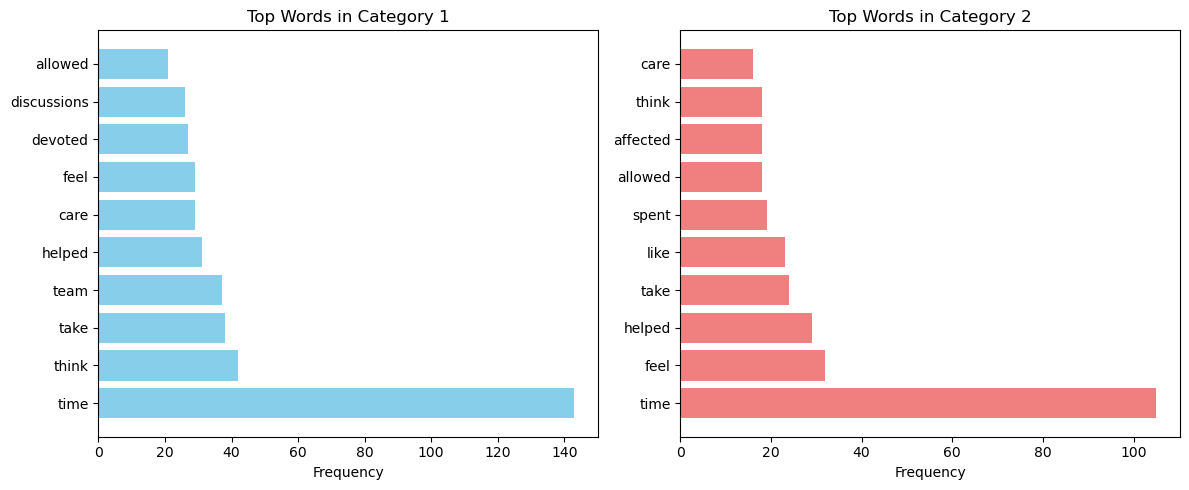

In [22]:
Q1_word_list = [word for sublist in sample['CPD_Q1'] for word in sublist]
Q3_word_list = [word for sublist in sample2['CPD_Q3'] for word in sublist]

Q1_word_freq = Counter(Q1_word_list)
Q3_word_freq = Counter(Q3_word_list)

# Plot the top N most frequent words
N = 10  # Change N to display more or fewer words
commonQ1_words = Q1_word_freq.most_common(N)
commonQ3_words = Q3_word_freq.most_common(N)

words1, frequencies1 = zip(*commonQ1_words)
words3, frequencies3 = zip(*commonQ3_words)

# Create a figure with two subplots (side by side)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.barh(words1, frequencies1, color='skyblue')
ax1.set_xlabel('Frequency')
ax1.set_title('Top Words in Category 1')


ax2.barh(words3, frequencies3, color='lightcoral')
ax2.set_xlabel('Frequency')
ax2.set_title('Top Words in Category 2')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()

### Stopword Analysis ###

Most Common 2-grams:
('time', 'spent'): 19
('feel', 'like'): 8
('spent', 'choice'): 7
('take', 'care'): 7
('self', 'care'): 6
('affected', 'positive'): 6
('felt', 'like'): 6
('time', 'spend'): 5
('positive', 'way'): 5
('taking', 'time'): 5


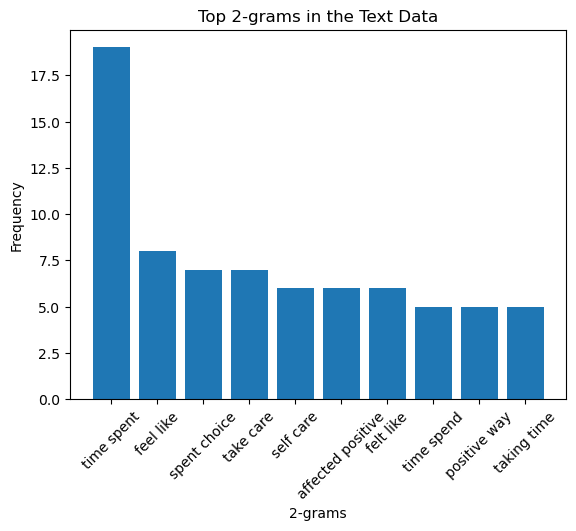

In [50]:
# Import the required libraries
import pandas as pd
import nltk
from nltk.util import ngrams
from nltk.tokenize import word_tokenize
from collections import Counter
import matplotlib.pyplot as plt

def extract_ngrams(tokens, n):
    return list(ngrams(tokens, n))

n = 2  # Set 'n' to the desired N-gram size (e.g., 2 for bigrams)

# Assuming 'sample2' is a DataFrame and 'CPD_Q3' column contains tokenized words
# If 'CPD_Q3' contains strings of comma-separated words, convert them to a list of words (tokens)
sample2['CPD_Q3'] = sample2['CPD_Q3'].apply(lambda x: x if isinstance(x, list) else x.split(','))

# Extract N-grams from the token lists
sample2['Ngrams'] = sample2['CPD_Q3'].apply(lambda x: extract_ngrams(x, n))

# Flatten the list of N-grams
ngrams_flat = [ngram for sublist in sample2['Ngrams'] for ngram in sublist]

# Count the frequency of each N-gram
ngram_counts = Counter(ngrams_flat)

# Display the most common N-grams and their frequencies
most_common_ngrams = ngram_counts.most_common(10)
print("Most Common {}-grams:".format(2))
for ngram, count in most_common_ngrams:
    print("{}: {}".format(ngram, count))

# Create a bar plot of the top N-grams
top_ngrams = dict(most_common_ngrams)
# Convert tuple bigrams into strings for plotting
bigram_strings = [' '.join(bigram) for bigram in top_ngrams.keys()]

plt.bar(range(len(top_ngrams)), top_ngrams.values())
plt.xlabel("{}-grams".format(n))
plt.ylabel("Frequency")
plt.title("Top {}-grams in the Text Data".format(n))
# Set the x-ticks to be the string representation of the bigrams
plt.xticks(range(len(top_ngrams)), bigram_strings, rotation=45)
plt.show()

Most Common 2-grams:
('time', 'devoted'): 25
('team', 'discussions'): 21
('take', 'care'): 15
('take', 'time'): 8
('self', 'care'): 6
('past', '3'): 6
('devoted', 'helped'): 5
('little', 'bit'): 5
('allowed', 'time'): 5
('quarters', 'time'): 5


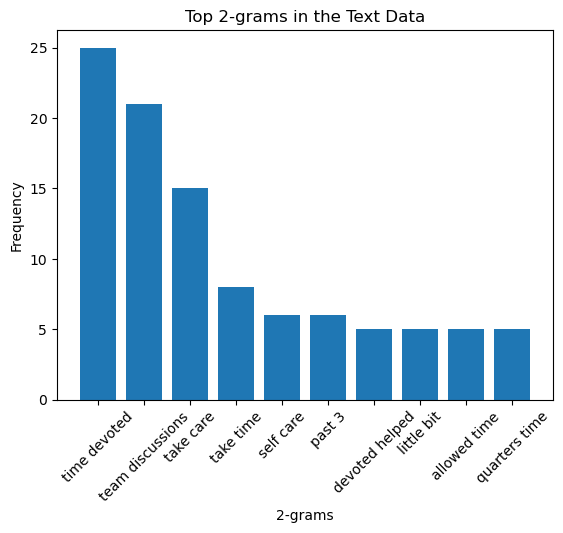

In [52]:
# Import the required libraries
import pandas as pd
import nltk
from nltk.util import ngrams
from nltk.tokenize import word_tokenize
from collections import Counter
import matplotlib.pyplot as plt

def extract_ngrams(tokens, n):
    return list(ngrams(tokens, n))

n = 2  # Set 'n' to the desired N-gram size (e.g., 2 for bigrams)

# Assuming 'sample' is a DataFrame and 'CPD_Q1' column contains tokenized words
# If 'CPD_Q1' contains strings of comma-separated words, convert them to a list of words (tokens)
sample['CPD_Q1'] = sample['CPD_Q1'].apply(lambda x: x if isinstance(x, list) else x.split(','))

# Extract N-grams from the token lists
sample['Ngrams'] = sample['CPD_Q1'].apply(lambda x: extract_ngrams(x, n))

# Flatten the list of N-grams
ngrams_flat = [ngram for sublist in sample['Ngrams'] for ngram in sublist]

# Count the frequency of each N-gram
ngram_counts = Counter(ngrams_flat)

# Display the most common N-grams and their frequencies
most_common_ngrams = ngram_counts.most_common(10)
print("Most Common {}-grams:".format(2))
for ngram, count in most_common_ngrams:
    print("{}: {}".format(ngram, count))

# Create a bar plot of the top N-grams
top_ngrams = dict(most_common_ngrams)
# Convert tuple bigrams into strings for plotting
bigram_strings = [' '.join(bigram) for bigram in top_ngrams.keys()]

plt.bar(range(len(top_ngrams)), top_ngrams.values())
plt.xlabel("{}-grams".format(n))
plt.ylabel("Frequency")
plt.title("Top {}-grams in the Text Data".format(n))
# Set the x-ticks to be the string representation of the bigrams
plt.xticks(range(len(top_ngrams)), bigram_strings, rotation=45)
plt.show()